# Word2Vec Embeddings

This notebook explores the Continuous Bag of Words (CBOW) word embedding strategy. After an embedding layer of a neural network is trained, it can be used as a look-up that returns a vector, typically of rank 100 to 300, for each word ID. Among the advantages of the projection of words into a vector space are the following:

* Word similarities and dissimilarities can be measured by distance.
* The dimensionality of the vocabulary is sharply reduced, which sharply improves computational efficiency.

This notebook implements the Word2Vec model (Mikolov, et al., 2013), which is the most common CBOW implementation. 

## Load the NLTK Inaugural Corpus

In [1]:
import numpy as np
from numpy.random import default_rng
import re
import string
from typing import List, Tuple

import nltk
from nltk.corpus import inaugural, stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import pylab as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.utils import to_categorical

from contractions import CONTRACTION_MAP

## Pre-process the corpus

Pre-processing will include the following steps:

* sentence tokenize
* lower case
* expand contractions
* remove numbers
* remove stopwords
* remove punctuation

The `contractions` module has been downloaded from Sarkar, D (2016) Text Analytics with Python \[Source code\] https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch03%20-%20Processing%20and%20Understanding%20Text/contractions.py

The `expand_match` and `expand_contractions` functions are adapted from (Sarker, D., 2019, p. 137)

In [2]:
contractions_pattern = '|'.join(CONTRACTION_MAP.keys())
contractions_rgx = re.compile(contractions_pattern)
numbers_rgx = re.compile(r"\d+")

def expand_match(contraction: re.Match) -> str:
    match = contraction.group(0)
    return CONTRACTION_MAP[match]

def expand_contractions(text: str) -> str:
    expanded_text = contractions_rgx.sub(expand_match, text)
    return expanded_text.replace("'", "")

stop_words = set(stopwords.words('english'))

def preprocess(doc: str) -> List[str]:
    """Return list of preprocessed sentences"""
    output: List[str] = []
    sentences = sent_tokenize(doc)
    for sentence in sentences:
        words: List[str] = []
        sentence = sentence.lower()
        sentence = expand_contractions(sentence)
        sentence = numbers_rgx.sub('', sentence)
        tokens = word_tokenize(sentence)
        for tok in tokens:
            if tok not in string.punctuation and \
                tok not in stop_words and \
                len(tok) > 2:
                words.append(tok)
        if len(words) > 0:
            output.append(' '.join(words))
    return output

docs: List[str] = []
for file_id in inaugural.fileids():
    docs.extend(preprocess(inaugural.raw(file_id)))

# verify the pre-processing by printing a couple sentences from the first inaugural and from the corpus
print(inaugural.raw(inaugural.fileids()[0])[:725])
print()
print(docs[:2])

Fellow-Citizens of the Senate and of the House of Representatives:

Among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the 14th day of the present month. On the one hand, I was summoned by my Country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years -- a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual

[&#39;fellow-citizens senate house representatives among vicissitudes incident life event could filled greater anxieties notification transmitted order received day present month&#39;, &#39;one hand summoned country whose voice never hear veneration love retreat chosen fon

## Create a corpus vocabulary

The following code cell is adapted from (Sarkar, D., 2019, p. 236).

In [3]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(docs)
word_id_map = tokenizer.word_index
word_id_map['PAD'] = 0
id_word_map = {v:k for k, v in word_id_map.items()}

# Verify by checking the vocabulary length and a sample of word, id tuples
print(f"Vocabulary contains {len(word_id_map)} words")
print("Vocabulary sample:", list(word_id_map.items())[:10])
print("Inverse vocabulary sample:", list(id_word_map.items())[:10])

Vocabulary contains 9011 words
Vocabulary sample: [(&#39;government&#39;, 1), (&#39;people&#39;, 2), (&#39;upon&#39;, 3), (&#39;must&#39;, 4), (&#39;great&#39;, 5), (&#39;may&#39;, 6), (&#39;states&#39;, 7), (&#39;shall&#39;, 8), (&#39;world&#39;, 9), (&#39;country&#39;, 10)]
Inverse vocabulary sample: [(1, &#39;government&#39;), (2, &#39;people&#39;), (3, &#39;upon&#39;), (4, &#39;must&#39;), (5, &#39;great&#39;), (6, &#39;may&#39;), (7, &#39;states&#39;), (8, &#39;shall&#39;), (9, &#39;world&#39;), (10, &#39;country&#39;)]


## (Context, Target) Generator

The generator function `generate_context_target_tuples()` yields a tuple of lists:

* a list of the context words that surround each target word in a sentence, and
* a single element list containing the corresponding target word

The list of context words adds "PAD" tokens as needed at the beginning and end of each sentence. 

The function borrows generously from (Sarkar, D., 2019, p. 237).

In [4]:
def generate_context_target_tuples(docs: List[str], window_size: int, vocab_size: int) -> Tuple[List[List[int]], List[int]]:
    """Generate the context of window_size words on each side of a word for every word in every doc
    
    Note
    ----
    Yields a tuple of window_size * 2 context words and a one-hot vector of the corresponding target word
    """
    len_context = window_size * 2
    for sentence in docs:
        len_sentence = len(sentence)
        for idx, word in enumerate(sentence):
            context_words: List[List[int]] = []
            label_word: List[int] = []
            start = idx - window_size
            end = idx + window_size + 1 # add 1 bc/of target word in the middle
            context_words.append([sentence[i] for i in range(start, end)
                                  if 0 <= i < len_sentence and i != idx])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=len_context)
            y = to_categorical(label_word, vocab_size)
            yield (x, y)

# Test with a couple sentences from the corpus
# Print out the first 5 context, target tuples
context = 0
target = 1
i = 0
corpus = np.array([[word_id_map[w] for w in text.text_to_word_sequence(sentence)] for sentence in docs])
for x, y in generate_context_target_tuples(corpus, window_size=2, vocab_size=len(word_id_map)):
    if 0 in x[context]:
        continue
    print("Context:", [id_word_map[w] for w in x[context]], 'Target:', id_word_map[np.argmax(y[0])])
    if i == 4:
        break
    i += 1


Context: [&#39;fellow&#39;, &#39;citizens&#39;, &#39;house&#39;, &#39;representatives&#39;] Target: senate
Context: [&#39;citizens&#39;, &#39;senate&#39;, &#39;representatives&#39;, &#39;among&#39;] Target: house
Context: [&#39;senate&#39;, &#39;house&#39;, &#39;among&#39;, &#39;vicissitudes&#39;] Target: representatives
Context: [&#39;house&#39;, &#39;representatives&#39;, &#39;vicissitudes&#39;, &#39;incident&#39;] Target: among
Context: [&#39;representatives&#39;, &#39;among&#39;, &#39;incident&#39;, &#39;life&#39;] Target: vicissitudes


### Prepare data for batch training

In order to accelerate the training steps with batching, the context <==> target pairs generated from the corpus are packaged as numpy arrays. This succeeds because the _inaugural_ corpus is small enough to fit in a laptop's memory. For a much larger corpus, a generator  parameterized by batch size would be essential.

In [8]:
context_arrays: List[List[int]] = []
targets: List[List[int]] = [] # Each list will have length 1
window_size = 2
vocab_size = len(word_id_map)
for x, y in generate_context_target_tuples(corpus, window_size=2, vocab_size=len(word_id_map)):
    context_arrays.append(x)
    targets.append(y)
x_train = np.array(context_arrays).reshape((len(context_arrays), window_size * 2))
y_train = np.array(targets, dtype='int8').reshape((len(targets), vocab_size))
print(x_train.shape, y_train.shape)

(63776, 4) (63776, 9011)


## CBOW Model

The CBOW model has the proxy task of predicting the target word given the context words. According to the distributional hypothesis, words that occur in similar contexts tend to have similar meanings (Wiki of the Association for Computational Linguistics, 2010). Consequently, the back-propagation of prediction error will cause target words with similar contexts to have similar weights in the  embedding layer.

Once the embedding layer has been trained, it can be used as a statespace into which vocabulary words are projected.

The code in the cell below is largely copied from (Sarkar, 2019, p. 239)

In [12]:
embed_size = 100

# CBOW Architecture
cbow = Sequential()
cbow.add(Embedding(input_dim = vocab_size, output_dim = embed_size, input_length = window_size * 2))
cbow.add(Lambda(lambda x: K.mean(x, axis = 1), output_shape = (embed_size,)))
cbow.add(Dense(vocab_size, activation = 'softmax'))
cbow.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002))

In [13]:
# view model summary
print(cbow.summary())

Model: &quot;sequential_2&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 100)            901100    
_________________________________________________________________
lambda_2 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9011)              910111    
Total params: 1,811,211
Trainable params: 1,811,211
Non-trainable params: 0
_________________________________________________________________
None


## Train Model

While (Sarkar, 2019) proposes a stochastic training methodolog, the batch cycle implemented in the code below is orders of magnitude faster.

In [14]:
# Train model
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'loss', verbose = 2, restore_best_weights = True)
tf.config.run_functions_eagerly(True)
cbow.fit(x_train, y_train, epochs = 20, callbacks = early_stopper, verbose = 2)

Epoch 1/20
1993/1993 - 47s - loss: 8.7352
Epoch 2/20
1993/1993 - 47s - loss: 8.1479
Epoch 3/20
1993/1993 - 47s - loss: 8.0171
Epoch 4/20
1993/1993 - 47s - loss: 7.9678
Epoch 5/20
1993/1993 - 47s - loss: 7.9357
Epoch 6/20
1993/1993 - 47s - loss: 7.9145
Epoch 7/20
1993/1993 - 47s - loss: 7.8981
Epoch 8/20
1993/1993 - 47s - loss: 7.8848
Epoch 9/20
1993/1993 - 47s - loss: 7.8736
Epoch 10/20
1993/1993 - 49s - loss: 7.8630
Epoch 11/20
1993/1993 - 48s - loss: 7.8518
Epoch 12/20
1993/1993 - 47s - loss: 7.8403
Epoch 13/20
1993/1993 - 48s - loss: 7.8285
Epoch 14/20
1993/1993 - 48s - loss: 7.8171
Epoch 15/20
1993/1993 - 48s - loss: 7.8064
Epoch 16/20
1993/1993 - 48s - loss: 7.7952
Epoch 17/20
1993/1993 - 48s - loss: 7.7843
Epoch 18/20
1993/1993 - 47s - loss: 7.7726
Epoch 19/20
1993/1993 - 47s - loss: 7.7612
Epoch 20/20
1993/1993 - 47s - loss: 7.7515


&lt;tensorflow.python.keras.callbacks.History at 0x1d7e0a25520&gt;

Because the loss has not yet reached a local minimum, why not continue? To do so, we have to set the `initial_epoch` parameter of the `Model.fit()` method so the optimizer will behave correctly when training resumes.

In [15]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss', 
    verbose = 2, 
    restore_best_weights = True,
    patience = 1,
)
cbow.fit(
    x_train, 
    y_train, 
    initial_epoch = 21,
    epochs = 100, 
    callbacks = early_stopper, 
    verbose = 2
)

Epoch 22/100
1993/1993 - 46s - loss: 7.7436
Epoch 23/100
1993/1993 - 47s - loss: 7.7379
Epoch 24/100
1993/1993 - 47s - loss: 7.7348
Epoch 25/100
Restoring model weights from the end of the best epoch.
1993/1993 - 47s - loss: 7.7348
Epoch 00025: early stopping


&lt;tensorflow.python.keras.callbacks.History at 0x1d98d61e5b0&gt;

## Use embeddings to find words nearest search terms

The weights in the model's embedding layer can now be used as a vector space. The ID of the vocabulary word can serve as the index into the embedding space.

The sample words used in this exercise are:

* 'citizens'
* 'life' 
* 'senate'
* 'know'

In [16]:
# get the word2vec embedding for our vocabulary
weights = cbow.get_weights()[0]

# find the 5 nearest words in the embedding space to 4 sample words
my_words = ['citizens', 'life', 'senate', 'know']
dist_matrix = euclidean_distances(weights)
similar_words = {
    search_word: [id_word_map[idx] for idx in dist_matrix[word_id_map[search_word]- 1].argsort()[1:6] + 1]
                    for search_word in my_words
}
similar_words


{&#39;citizens&#39;: [&#39;institutions&#39;, &#39;peoples&#39;, &#39;governments&#39;, &#39;economic&#39;, &#39;attempt&#39;],
 &#39;life&#39;: [&#39;degree&#39;, &#39;effort&#39;, &#39;opinion&#39;, &#39;legislature&#39;, &#39;highest&#39;],
 &#39;senate&#39;: [&#39;presently&#39;, &#39;disapproved&#39;, &#39;tasked&#39;, &#39;heartened&#39;, &#39;allocating&#39;],
 &#39;know&#39;: [&#39;half&#39;, &#39;afford&#39;, &#39;ultimately&#39;, &#39;favored&#39;, &#39;questions&#39;]}

## Visualize distances in word embeddings space

The T-SNE algorithm is used to project the search terms and nearest neighbors into a 2-dimensional space. 


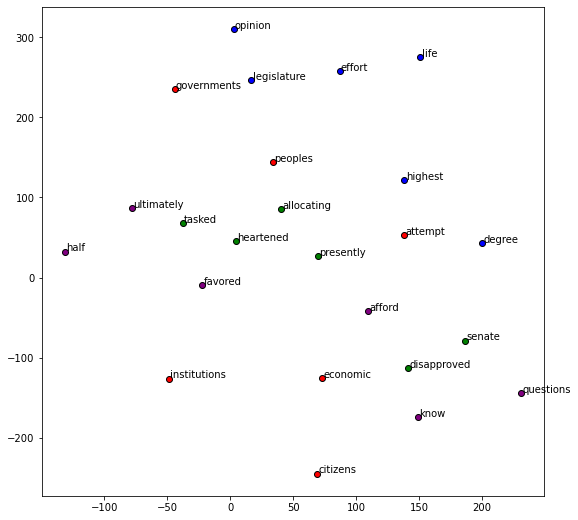

In [19]:
colors = ["red", "blue", "green", "purple"]
words: List[str] = []
for (k, v) in similar_words.items():    
    words.append(k)
    words += v
word_ids = [word_id_map[w] for w in words]
vecs = np.array([weights[w_id] for w_id in word_ids])
tsne = TSNE(n_components=2, random_state=42, n_iter=20000, perplexity=3)
np.set_printoptions(suppress=True)
projection = tsne.fit_transform(vecs)
labels = words
plt.figure(figsize=(9, 9))
start = 0
end = 0
for i, color in enumerate(colors):
    end += 6
    plt.scatter(projection[start:end,0], projection[start:end,1], c=color, edgecolors='k')
    start += 6
for label, x, y in zip(labels, projection[:,0], projection[:,1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

Let's annotate the graph to show the groupings: 

<img src="./tsne.png" width="428" height="396" /> 

The result is not ideal. The red group is split in two; the groups are somewhat amorphous; and the groups are close to one another. That said, the T-SNE plot does succeeds in clustering the groups visually.


## Summary

### Does Word2Vec cluster similar words?

This experiment provides some support for the distributional hypothesis: 

* The four nearest words to _citizens_ in the embedding space were _institutions, peoples, governments, and economic_, which is a logical cluster. 
* The second closest word to _life_ was _effort_, which is a sensible outcome. 
* Three of the closest words to _senate_ were _disapproved, tasked, and allocating_, which seem to describe activities expected of the U.S. Senate. 

However, other outcomes were more puzzling: the closest word to _senate_ was _presently_, and the closest word to _know_ was _half_. 

### Practical use of Word2Vec embeddings

While the projection of words into an embedding space seems elegant from the standpoint of the distributional hypothesis, in practice it is fraught with difficulty. I ran into two major problems:

1. Loss was increasing with each epoch. When I debugged into the training code, I saw that loss was decreasing early on. By the time an epoch had been reached, however, it was already increasing. The learning rate was set too large in the optimizer, causing the local minimum to be overshot. I solved the problem by decreasing the learning rate.

2. The T-SNE projection was noisy. Perhaps a larger corpus would yield better differentiation.

For this reason, the practitioner is advised to use a pre-trained embedding, or perhaps to use a different pre-trained embedding such as GloVe.


## References

Mikolov, T. et al. (September 7, 2013). _Efficient Estimation of Word Representations in Vector Space_. ArXiv.org. https://arxiv.org/pdf/1301.3781.pdf

Sarkar, D. (2019). _Text Analytics with Python, Second Edition_. Apress

Wiki of the Association for Computational Linguistics (2010). _Distributional Hypothesis_. https://aclweb.org/aclwiki/Distributional_Hypothesis